In [18]:
%load_ext autoreload
%autoreload 1
from pathlib import Path

import pandas as pd
import seaborn as sns
import torch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch.utils.data import Subset, WeightedRandomSampler
# from torch.utils.data import DataLoader
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = True # set to True if running on SCITAS cluster
LOCAL_DATA_ROOT = Path("./data")
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else LOCAL_DATA_ROOT
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [ ]:
import subprocess

# execute feature extraction script
process = None
try:
    process = subprocess.Popen(["python3", "scripts/feature_extractor.py"])
    process.wait()
except KeyboardInterrupt:
    print("Process interrupted, terminating...")
    if process:
        process.terminate()
        process.wait()
except Exception as e:
    print(f"Error occurred: {e}")
    if process:
        process.terminate()
        process.wait()


🧠 EEG FEATURE EXTRACTION PIPELINE (Full Refactored Script)
⏰ Started at: 2025-06-08 13:10:16
💻 System info: 40 CPU cores available
📈 Features per channel: 35, Expected channels: 19
🔧 Config: verbose=True, test_mode=False, max_workers=16
🔍 Using INPUT_DATA_ROOT: /home/ogut/data
🔍 Using OUTPUT_DATA_ROOT: /home/ldibello/NeuroGraphNet/data

📊 REFINED EEG FEATURE EXTRACTION DETAILS:
   Features per channel: 35
   Total expected features per segment (for 19 channels): 665
   Parallel processing with up to 16 workers.

✅ Loaded segment metadata: Train (12993, 6), Test (3614, 5)
   Training segments (valid labels): (12993, 6)
   Test segments: (3614, 5)

🔧 Designing filters: BP=(0.5, 50.0)Hz, Notch=60.0Hz (Q=30.0), FS=250Hz

⏳ Processing Training Set...
   Total training session groups: 177

🚀 Starting parallel training set processing (177 groups)...


Train Sessions:  18%|█▊        | 32/177 [05:35<25:19, 10.48s/it]

🔄 [PID:2081043] Starting: ('pqejgcsv', 's001_t000') (42 segs) at 13:10:17
    📁 Loading: /home/ogut/data/train/signals/pqejgcsv_s001_t000.parquet
    🕒 [PID:2081043] ('pqejgcsv', 's001_t000') - Reading parquet - Elap: 0.0s - Mem: 126.1MB
    ✅ Loaded signal (128500, 19) in 0.26s
    🕒 [PID:2081043] ('pqejgcsv', 's001_t000') - Filtering, Rereferencing & Normalization - Elap: 0.3s - Mem: 184.5MB
    ✅ Filtering, CAR Rereferencing & Normalization done in 0.19s
    🕒 [PID:2081043] ('pqejgcsv', 's001_t000') - Segment 1/42 - Elap: 0.5s - Mem: 240.9MB
        ❌ Error processing segment 1 (orig_idx ('pqejgcsv', 's001_t000', 0)) for ('pqejgcsv', 's001_t000'): module 'numpy' has no attribute 'trapezoid'
    🕒 [PID:2081043] ('pqejgcsv', 's001_t000') - Segment 2/42 - Elap: 55.2s - Mem: 241.1MB
        ❌ Error processing segment 2 (orig_idx ('pqejgcsv', 's001_t000', 1)) for ('pqejgcsv', 's001_t000'): module 'numpy' has no attribute 'trapezoid'
    🕒 [PID:2081043] ('pqejgcsv', 's001_t000') - Segment

In [3]:
# spacial distance matrix between sensors
spatial_distance_file = LOCAL_DATA_ROOT / "distances_3d.csv"

# training data
train_dir = DATA_ROOT / "train"
train_dir_metadata = train_dir / "segments.parquet"
train_dataset_dir = LOCAL_DATA_ROOT / "graph_dataset_train"

# test data
test_dir = DATA_ROOT / "test"
test_dir_metadata = test_dir / "segments.parquet"
test_dataset_dir = LOCAL_DATA_ROOT / "graph_dataset_test"

# additional features
extracted_features_dir = LOCAL_DATA_ROOT / "extracted_features"
embeddings_dir =  LOCAL_DATA_ROOT / "embeddings"

In [4]:
from src.utils.index import ensure_eeg_multiindex 

# Load clips from datasets
clips_tr = pd.read_parquet(train_dir_metadata)
clips_tr = ensure_eeg_multiindex(clips_tr)
clips_tr['id'] = clips_tr.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_tr.id.nunique() == len(clips_tr), "There are duplicate IDs"
clips_tr = clips_tr[~clips_tr.label.isna()].reset_index()

# Load clips from datasets
clips_te = pd.read_parquet(test_dir_metadata)
clips_te = ensure_eeg_multiindex(clips_te)
clips_te['id'] = clips_te.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_te.id.nunique() == len(clips_te), "There are duplicate IDs"
clips_te = clips_te.reset_index()

# sort in order to maintain the same submission order
clips_te = clips_te.sort_values(by="id")

In [5]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# dataset settings
selected_features = []
embeddings = []
edge_strategy = "spatial"
correlation_threshold = 0.5
top_k = None
low_bandpass_frequency = 0.5
high_bandpass_frequency = 50

# additional settings
oversampling_power = 1.0

# load training dataset
dataset_tr = GraphEEGDataset(
    root=train_dataset_dir,
    clips=clips_tr,
    signal_folder=train_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy=edge_strategy,
    spatial_distance_file=(
        spatial_distance_file if edge_strategy == "spatial" else None
    ),
    top_k=top_k,
    correlation_threshold=correlation_threshold,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=False,
    apply_normalization=False,
    sampling_rate=250,
)

# Check the length of the dataset
print(f"Length of train_dataset: {len(dataset_tr)}")
print(f' Eliminated IDs: {dataset_tr.ids_to_eliminate}')

# Eliminate ids that did not have electrodes above correlation threshols
clips_tr = clips_tr[~clips_tr.index.isin(dataset_tr.ids_to_eliminate)]

Modules to reload:


Modules to skip:



2025-06-08 11:18:40 - INFO - Initializing GraphEEGDataset...
2025-06-08 11:18:40 - INFO - Dataset parameters:
2025-06-08 11:18:40 - INFO -   - Root directory: data/graph_dataset_train
2025-06-08 11:18:40 - INFO -   - Edge strategy: spatial
2025-06-08 11:18:40 - INFO -   - Top-k neighbors: None
2025-06-08 11:18:40 - INFO -   - Correlation threshold: 0.5
2025-06-08 11:18:40 - INFO -   - Force reprocess: False
2025-06-08 11:18:40 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-08 11:18:40 - INFO -   - Segment length: 3000
2025-06-08 11:18:40 - INFO -   - Apply filtering: True
2025-06-08 11:18:40 - INFO -   - Apply rereferencing: False
2025-06-08 11:18:40 - INFO -   - Apply normalization: False
2025-06-08 11:18:40 - INFO -   - Sampling rate: 250
2025-06-08 11:18:40 - INFO -   - Test mode: False
2025-06-08 11:18:40 - INFO - Number of EEG channels: 19
2025-06-08 11:18:40 - INFO - Setting up signal filters...
2025-06-08 11:18:40 - INFO - Loading spatial distances from data/distances_3d.c

Length of train_dataset: 12993
 Eliminated IDs: []


In [6]:
print(clips_te.columns)

Index(['patient', 'session', 'segment', 'start_time', 'end_time', 'date',
       'sampling_rate', 'signals_path', 'id'],
      dtype='object')


In [7]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load test dataset
te_dataset = GraphEEGDataset(
    root=test_dataset_dir,
    clips=clips_te,
    signal_folder=test_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="spatial",
    spatial_distance_file=spatial_distance_file,
    top_k=None,
    correlation_threshold=0.5,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=False,
    apply_normalization=False,
    sampling_rate=250,
    is_test = True,
)

# Check the length of the dataset
print(f"Length of test_dataset: {len(te_dataset)}")
print(f' Eliminated IDs:{te_dataset.ids_to_eliminate}')

# Eliminate ids that did not have electrodes above correlation threshols
clips_te = clips_te[~clips_te.index.isin(te_dataset.ids_to_eliminate)].reset_index(drop=True)

2025-06-08 11:18:40 - INFO - Initializing GraphEEGDataset...
2025-06-08 11:18:40 - INFO - Dataset parameters:
2025-06-08 11:18:40 - INFO -   - Root directory: data/graph_dataset_test
2025-06-08 11:18:40 - INFO -   - Edge strategy: spatial
2025-06-08 11:18:40 - INFO -   - Top-k neighbors: None
2025-06-08 11:18:40 - INFO -   - Correlation threshold: 0.5
2025-06-08 11:18:40 - INFO -   - Force reprocess: False
2025-06-08 11:18:40 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-08 11:18:40 - INFO -   - Segment length: 3000
2025-06-08 11:18:40 - INFO -   - Apply filtering: True
2025-06-08 11:18:40 - INFO -   - Apply rereferencing: False
2025-06-08 11:18:40 - INFO -   - Apply normalization: False
2025-06-08 11:18:40 - INFO -   - Sampling rate: 250
2025-06-08 11:18:40 - INFO -   - Test mode: True
2025-06-08 11:18:40 - INFO - Number of EEG channels: 19
2025-06-08 11:18:40 - INFO - Setting up signal filters...
2025-06-08 11:18:40 - INFO - Loading spatial distances from data/distances_3d.csv

Modules to reload:


Modules to skip:

Length of test_dataset: 3614
 Eliminated IDs:[]


In [8]:
import numpy as np
from src.utils.general_funcs import labels_stats

# Get total samples and split sizes
total_samples = len(dataset_tr)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Get labels for initial split
y = clips_tr["label"].values

# Create initial train/val split using random permutation
indices = torch.randperm(total_samples)
train_indices = indices[:train_size].numpy()
val_indices = indices[train_size:].numpy()

print('Labels before split', flush=True)
print(y, flush=True)

# Print stats for class 0 and 1
labels_stats(y, train_indices, val_indices)

# Create train and val datasets
train_dataset = Subset(dataset_tr, train_indices)
val_dataset = Subset(dataset_tr, val_indices)

# 3. Compute sample weights for oversampling
train_labels = [clips_tr.iloc[i]["label"] for i in train_indices]
class_counts = np.bincount(train_labels)
class_weights = (1. / class_counts) ** oversampling_power  # Higher weights for not frequent classes
sample_weights = [class_weights[label] for label in train_labels]  # Assign weight to each sample based on its class

# 4. Define sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define dataloaders
BATCH_SIZE = 64
train_loader = GeoDataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)
val_loader = GeoDataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)
te_loader = GeoDataLoader(
    te_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(te_loader)}")

Labels before split
[1 1 1 ... 1 1 0]
[11:18:40] Train labels: 0 -> 8375, 1 -> 2019
[11:18:40] Val labels:   0 -> 2101, 1 -> 498
Train batches: 163
Val batches: 41
Test batches: 57


In [9]:
%aimport
import torch.optim as optim
import torch.nn as nn
from src.layers.hybrid.cnn_bilstm_gcn import EEGCNNBiLSTMGCN
from src.utils.train import train_model
from src.utils.plot import plot_training_loss

config = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "patience": 10,
    "epochs": 100,
}

Modules to reload:


Modules to skip:



In [11]:
def wrap_train(model, save_path):
    model = model.to(device)
    # optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    # optimizer = Lion(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5)
    loss = nn.BCEWithLogitsLoss()  # Not weighted as we use a balanced sampler!

    # train model
    train_history, val_history = train_model(
        wandb_config=None,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=loss,
        scheduler=scheduler,
        optimizer=optimizer,
        device=device,
        num_epochs=config["epochs"],
        patience=config["patience"],
        save_path=save_path,
        use_gnn=True,
        # hidden attribute
        try_load_checkpoint=True,
    )
    plot_training_loss(train_history["loss"], val_history["loss"])

### Test 3 - First breakthrough model

In [19]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_3.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 128,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 3,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

2025-06-08 03:16:07 - INFO - Starting training setup...
2025-06-08 03:16:07 - INFO - Model type: GNN
2025-06-08 03:16:07 - INFO - Device: cuda


2025-06-08 03:16:07 - INFO - Batch size: 64
2025-06-08 03:16:07 - INFO - Number of epochs: 100
2025-06-08 03:16:07 - INFO - Patience: 10
2025-06-08 03:16:07 - INFO - Monitor metric: val_f1
2025-06-08 03:16:07 - INFO - Initializing wandb...


2025-06-08 03:16:09 - INFO - Total training batches per epoch: 163
2025-06-08 03:16:09 - INFO - Starting training from epoch 1 to 100


🔗 Wandb initialized: cnn_bilstm_gcn_test_3


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 03:16:09 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 03:16:10 - INFO - Processing batch 1/163
2025-06-08 03:16:10 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 03:16:10 - INFO - Batch 1/163 - Loss: 0.7152 - Avg batch time: 0.26s
2025-06-08 03:16:13 - INFO - Processing batch 11/163
2025-06-08 03:16:14 - INFO - Batch 11/163 - Loss: 0.6780 - Avg batch time: 0.25s
2025-06-08 03:16:17 - INFO - Processing batch 21/163
2025-06-08 03:16:18 - INFO - Batch 21/163 - Loss: 0.6435 - Avg batch time: 0.25s
2025-06-08 03:16:21 - INFO - Processing batch 31/163
2025-06-08 03:16:21 - INFO - Batch 31/163 - Loss: 0.6485 - Avg batch time: 0.25s
2025-06-08 03:16:25 - INFO - Processing batch 41/163
2025-06-08 03:16:25 - INFO - Batch 41/163 - Loss: 0.6078 - Avg batch time: 0.25s
2025-06-08 03:16:28 -

: 

### Test 4 - Smaller CGN output channels

2025-06-08 11:19:36 - INFO - Starting training setup...
2025-06-08 11:19:36 - INFO - Model type: GNN
2025-06-08 11:19:36 - INFO - Device: cuda
2025-06-08 11:19:36 - INFO - Batch size: 64
2025-06-08 11:19:36 - INFO - Number of epochs: 100
2025-06-08 11:19:36 - INFO - Patience: 10
2025-06-08 11:19:36 - INFO - Monitor metric: val_f1
2025-06-08 11:19:36 - INFO - Initializing wandb...
wandb: Currently logged in as: lucadibello (lucadibello-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


2025-06-08 11:19:42 - INFO - Total training batches per epoch: 163
2025-06-08 11:19:42 - INFO - Starting training from epoch 1 to 100


🔗 Wandb initialized: cnn_bilstm_gcn_test_4


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 11:19:42 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 11:19:44 - INFO - Processing batch 1/163
2025-06-08 11:19:44 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 11:19:50 - INFO - Batch 1/163 - Loss: 0.7148 - Avg batch time: 6.82s
2025-06-08 11:19:53 - INFO - Processing batch 11/163
2025-06-08 11:19:53 - INFO - Batch 11/163 - Loss: 0.6362 - Avg batch time: 0.25s
2025-06-08 11:20:01 - INFO - Processing batch 21/163
2025-06-08 11:20:01 - INFO - Batch 21/163 - Loss: 0.6606 - Avg batch time: 0.25s
2025-06-08 11:20:08 - INFO - Processing batch 31/163
2025-06-08 11:20:09 - INFO - Batch 31/163 - Loss: 0.5839 - Avg batch time: 0.25s
2025-06-08 11:20:16 - INFO - Processing batch 41/163
2025-06-08 11:20:16 - INFO - Batch 41/163 - Loss: 0.6031 - Avg batch time: 0.25s
2025-06-08 11:20:23 -

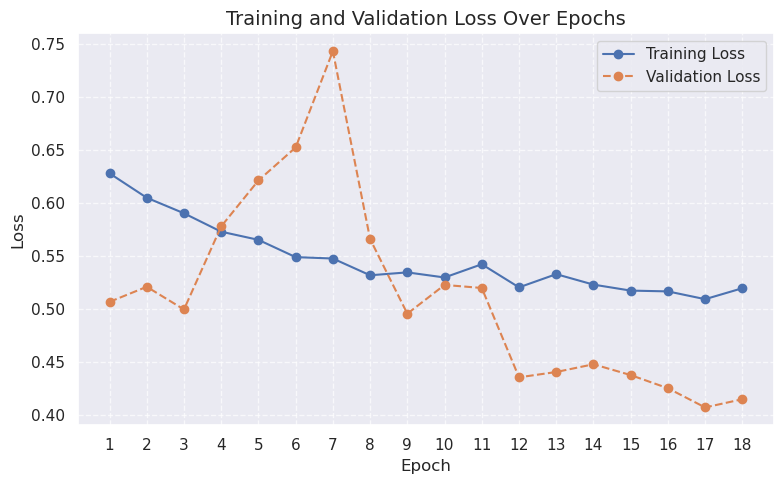

In [12]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_4.pt"

model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 3,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

### Test 5 - Smaller GCN output channels + increased embedding length + Deeper GCN

2025-06-08 11:45:15 - INFO - Starting training setup...
2025-06-08 11:45:15 - INFO - Model type: GNN
2025-06-08 11:45:15 - INFO - Device: cuda
2025-06-08 11:45:15 - INFO - Batch size: 64
2025-06-08 11:45:15 - INFO - Number of epochs: 100
2025-06-08 11:45:15 - INFO - Patience: 10
2025-06-08 11:45:15 - INFO - Monitor metric: val_f1
2025-06-08 11:45:15 - INFO - Initializing wandb...


bad_epochs,▁▁▁▁▁▁▂▃▁▂▃▃▄▅▆▆▇█
best_val_f1,▁▄▅▅▆▆▆██████████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
learning_rate,███████▃▃▃▃▃▃▁▁▁▁▁
train/accuracy,▁▃▄▅▅▆▆▇▆▇▆█▇█████
train/auroc,▁▃▄▅▅▆▆▇▇▇▆▇▇▇████
train/f1,▁▂▃▄▄▆▅▆▆▆▆█▇▇▇███
train/loss,█▇▆▅▄▃▃▂▂▂▃▂▂▂▁▁▁▂
val/accuracy,▇▇▇▆▆▄▁▇███▇██████
val/auroc,▁▂▃▃▃▄▅▆▅▄▄▇▇▅▆▇██
val/f1,▁▄▅▅▆▄▁█▇▅▃▇▇▃▅▇█▇


2025-06-08 11:45:17 - INFO - Total training batches per epoch: 163
2025-06-08 11:45:17 - INFO - Starting training from epoch 1 to 100


🔗 Wandb initialized: cnn_bilstm_gcn_test_5


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 11:45:17 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 11:45:18 - INFO - Processing batch 1/163
2025-06-08 11:45:18 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 11:45:18 - INFO - Batch 1/163 - Loss: 0.6839 - Avg batch time: 0.26s
2025-06-08 11:45:22 - INFO - Processing batch 11/163
2025-06-08 11:45:22 - INFO - Batch 11/163 - Loss: 0.6662 - Avg batch time: 0.25s
2025-06-08 11:45:25 - INFO - Processing batch 21/163
2025-06-08 11:45:26 - INFO - Batch 21/163 - Loss: 0.6016 - Avg batch time: 0.25s
2025-06-08 11:45:29 - INFO - Processing batch 31/163
2025-06-08 11:45:29 - INFO - Batch 31/163 - Loss: 0.6227 - Avg batch time: 0.25s
2025-06-08 11:45:33 - INFO - Processing batch 41/163
2025-06-08 11:45:33 - INFO - Batch 41/163 - Loss: 0.5623 - Avg batch time: 0.25s
2025-06-08 11:45:37 -

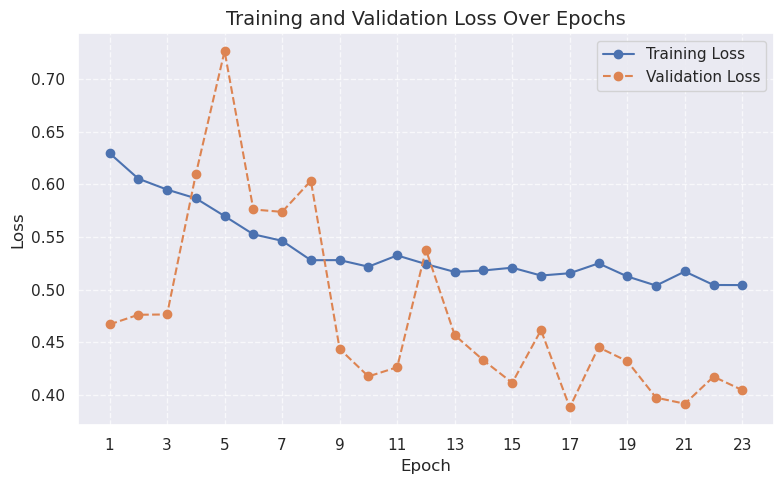

In [13]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_5.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)


### Test 6: slighly bigger GCN output channels
>[HIGHEST F1 SCORE EVER RECORDED]
```
✅ Checkpoint loaded. Resuming from epoch 33. Best 'val_f1' score: 0.7346
```

2025-06-08 12:15:44 - INFO - Starting training setup...
2025-06-08 12:15:44 - INFO - Model type: GNN
2025-06-08 12:15:44 - INFO - Device: cuda
2025-06-08 12:15:44 - INFO - Batch size: 64
2025-06-08 12:15:44 - INFO - Number of epochs: 100
2025-06-08 12:15:44 - INFO - Patience: 10
2025-06-08 12:15:44 - INFO - Monitor metric: val_f1
2025-06-08 12:15:44 - INFO - Initializing wandb...


bad_epochs,▁▁▁▁▁▂▁▂▃▃▁▁▂▁▂▃▃▄▅▆▆▇█
best_val_f1,▁▁▄▆▆▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
learning_rate,███████▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁
train/accuracy,▁▂▃▃▄▅▆▇▇▇▆▇█▇▇▇█▇██▇██
train/auroc,▁▃▃▄▅▆▆▇▇▇▇▇▇▇▇██▇█████
train/f1,▁▂▃▃▃▄▅▅▆▇▇▇▇▇▇▇█▇▇█▇██
train/loss,█▇▆▆▅▄▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁
val/accuracy,▇▇▇▅▁▇▆▅███████████████
val/auroc,▁▁▂▃▄▅▅▆▆██▅▇▇▆▅▇▅▆▇█▇▇
val/f1,▁▁▄▆▄▇▇▆▇██▇██▆▇▇▅▇▇█▇▇


2025-06-08 12:15:46 - INFO - Total training batches per epoch: 163
2025-06-08 12:15:46 - INFO - Starting training from epoch 1 to 100


🔗 Wandb initialized: cnn_bilstm_gcn_test_6


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 12:15:46 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 12:15:47 - INFO - Processing batch 1/163
2025-06-08 12:15:47 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 12:15:47 - INFO - Batch 1/163 - Loss: 0.7326 - Avg batch time: 0.31s
2025-06-08 12:15:51 - INFO - Processing batch 11/163
2025-06-08 12:15:51 - INFO - Batch 11/163 - Loss: 0.6901 - Avg batch time: 0.25s
2025-06-08 12:15:55 - INFO - Processing batch 21/163
2025-06-08 12:15:55 - INFO - Batch 21/163 - Loss: 0.6974 - Avg batch time: 0.25s
2025-06-08 12:15:59 - INFO - Processing batch 31/163
2025-06-08 12:15:59 - INFO - Batch 31/163 - Loss: 0.6583 - Avg batch time: 0.25s
2025-06-08 12:16:02 - INFO - Processing batch 41/163
2025-06-08 12:16:03 - INFO - Batch 41/163 - Loss: 0.6355 - Avg batch time: 0.25s
2025-06-08 12:16:06 -

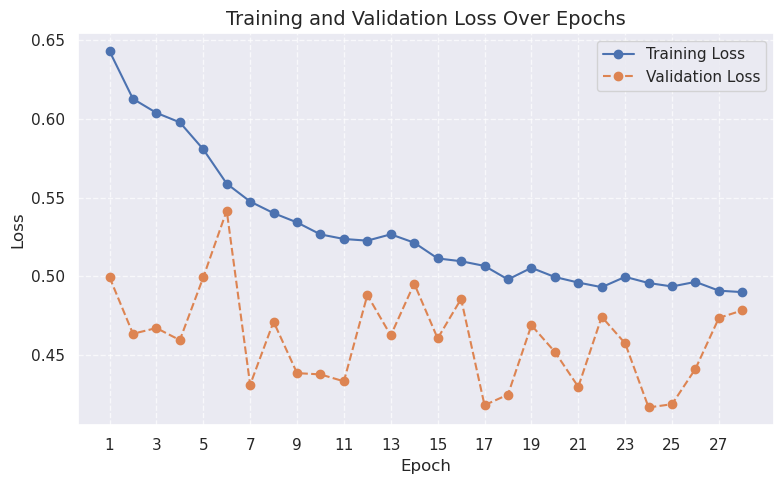

In [14]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_6.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

### Test 7B: Alternative architecture to improve generalization

In [15]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_8.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

2025-06-08 12:52:27 - INFO - Starting training setup...
2025-06-08 12:52:27 - INFO - Model type: GNN
2025-06-08 12:52:27 - INFO - Device: cuda
2025-06-08 12:52:27 - INFO - Batch size: 64
2025-06-08 12:52:27 - INFO - Number of epochs: 100
2025-06-08 12:52:27 - INFO - Patience: 10
2025-06-08 12:52:27 - INFO - Monitor metric: val_f1
2025-06-08 12:52:27 - INFO - Initializing wandb...


bad_epochs,▁▁▂▁▁▁▁▁▂▃▃▄▅▁▂▃▃▄▁▂▃▃▄▅▆▆▇█
best_val_f1,▁▁▁▄▅▅▇▇▇▇▇▇███████████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
learning_rate,████████▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/accuracy,▁▃▃▃▄▅▅▆▆▇▆▇▆▇▇▇▇█▇███▇█████
train/auroc,▁▂▃▃▄▅▆▆▆▆▇▇▆▇▇▇▇█▇▇████████
train/f1,▃▂▁▁▂▃▄▅▅▆▆▆▆▆▆▇▇█▇▇▇█▇▇█▇██
train/loss,█▇▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val/accuracy,▁▄▃▄▃▄▅▆▆▇▇▇█▇▇▆▆█▆▇▇▆▇▇▆▇▆▆
val/auroc,▁▂▂▄▄▃▆▇▇█▆▆▇▅▆▅▇█▆▇▇▇▆▇▇▆▄▃
val/f1,▁▁▂▄▅▆▇▄▄▆▅▅█▅▆▄▃█▃▅▅▄▅▅▃▅▂▂


2025-06-08 12:52:29 - INFO - Total training batches per epoch: 163
2025-06-08 12:52:29 - INFO - Starting training from epoch 1 to 100


🔗 Wandb initialized: cnn_bilstm_gcn_test_8


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 12:52:29 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 12:52:30 - INFO - Processing batch 1/163
2025-06-08 12:52:30 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 12:52:30 - INFO - Batch 1/163 - Loss: 0.7309 - Avg batch time: 0.26s
2025-06-08 12:52:34 - INFO - Processing batch 11/163
2025-06-08 12:52:34 - INFO - Batch 11/163 - Loss: 0.6821 - Avg batch time: 0.25s
2025-06-08 12:52:38 - INFO - Processing batch 21/163
2025-06-08 12:52:38 - INFO - Batch 21/163 - Loss: 0.6821 - Avg batch time: 0.25s
2025-06-08 12:52:42 - INFO - Processing batch 31/163
2025-06-08 12:52:42 - INFO - Batch 31/163 - Loss: 0.6497 - Avg batch time: 0.25s
2025-06-08 12:52:45 - INFO - Processing batch 41/163
2025-06-08 12:52:46 - INFO - Batch 41/163 - Loss: 0.7019 - Avg batch time: 0.25s
2025-06-08 12:52:49 -

KeyboardInterrupt: 

### Test 7C: slightly bigger GCN layers

BEST MODEL YET!

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_bigger.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm = True,
    encoder_use_layer_norm = False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_pooling_type = "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

### Test 7D: even bigger GCN layers

Comparable performance to best model. We might need to increase the number of GCN layers

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_bigger.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm = True,
    encoder_use_layer_norm = False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_pooling_type = "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)
wrap_train(model, SAVE_PATH)

### Test 7E: increased number of GCN layers

Assumption: the previous model was unable to learn enough, maybe the GCN was unable to capture

```
Epochs:   9%| | 9/100 [17:54<3:23:31, 134.20s/it, train_loss=0.4532, val_loss=0.3489, best_val_f1=0.6695, lr=5.00e-05, b2025-06-07 17:01:05 - INFO - 
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7F: Increased number of BiLSTM layers + Test 7E architecture

Assumpion: we saw a drammatical increase in accuracy by increasing the number of GCN layers. This hints that the model was now able to learn the most from the embeddings. To improve the performance even further without having to increase the number of GCN layers even more (overall reduce complexity, improve generalization), we will try to increase the number of BiLSTM layers. 

Using multiple BiLSTM layers will allow embeddings to be processed in a more complex way, potentially capturing more intricate relationships in the data. The GCN layers will take care of the graph structure, while the BiLSTM layers will enhance the temporal dependencies and relationships in the data.


In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

```
Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-07 18:55:16 - INFO -
Epochs:   2%| | 2/100 [04:35<7:29:19, 275.10s/it, train_loss=0.6212, val_loss=0.4619, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 18:59:51 - INFO -
Epochs:   3%| | 3/100 [09:09<7:23:49, 274.53s/it, train_loss=0.5819, val_loss=0.4295, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:04:25 - INFO -
Epochs:   4%| | 4/100 [13:42<7:18:31, 274.08s/it, train_loss=0.5628, val_loss=0.4437, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:08:59 - INFO -
Epochs:   5%| | 5/100 [18:16<7:13:28, 273.78s/it, train_loss=0.5452, val_loss=0.3942, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:13:32 - INFO -
Epochs:   6%| | 6/100 [22:49<7:08:41, 273.63s/it, train_loss=0.5334, val_loss=0.4563, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:18:05 - INFO -
Epochs:   7%| | 7/100 [27:22<7:04:01, 273.57s/it, train_loss=0.5319, val_loss=0.3738, best_val_f1=0.5137, lr=1.00e-04, b2025-06-07 19:22:39 - INFO -
Epochs:   8%| | 8/100 [31:56<6:59:20, 273.48s/it, train_loss=0.5181, val_loss=0.4369, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:27:12 - INFO -
Epochs:   9%| | 9/100 [36:29<6:54:50, 273.52s/it, train_loss=0.5220, val_loss=0.4202, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:31:46 - INFO -
Epochs:  10%| | 10/100 [41:03<6:50:17, 273.52s/it, train_loss=0.5286, val_loss=0.4167, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:36:19 - INFO -
Epochs:  11%| | 11/100 [45:36<6:45:44, 273.53s/it, train_loss=0.5065, val_loss=0.3864, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:40:53 - INFO -
Epochs:  12%| | 12/100 [50:10<6:41:03, 273.45s/it, train_loss=0.5158, val_loss=0.5175, best_val_f1=0.5695, lr=5.00e-05, 2025-06-07 19:45:26 - INFO -
Epochs:  13%|▏| 13/100 [54:43<6:36:23, 273.37s/it, train_loss=0.5035, val_loss=0.3785, best_val_f1=0.5940, lr=5.00e-05, 2025-06-07 19:49:59 - INFO -
Epochs:  14%|▏| 14/100 [59:16<6:31:50, 273.38s/it, train_loss=0.4842, val_loss=0.3838, best_val_f1=0.5981, lr=5.00e-05, 2025-06-07 19:54:33 - INFO -
Epochs:  15%|▏| 15/100 [1:03:50<6:27:17, 273.38s/it, train_loss=0.4644, val_loss=0.3493, best_val_f1=0.6106, lr=5.00e-052025-06-07 19:59:06 - INFO -
Epochs:  16%|▏| 16/100 [1:08:23<6:22:46, 273.41s/it, train_loss=0.4887, val_loss=0.3737, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:03:39 - INFO -
Epochs:  17%|▏| 17/100 [1:12:57<6:18:12, 273.41s/it, train_loss=0.4775, val_loss=0.3565, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:08:13 - INFO -
Epochs:  18%|▏| 18/100 [1:17:30<6:13:42, 273.44s/it, train_loss=0.4635, val_loss=0.3704, best_val_f1=0.6106, lr=2.50e-052025-06-07 20:12:46 - INFO -
Epochs:  19%|▏| 19/100 [1:22:04<6:09:15, 273.53s/it, train_loss=0.4501, val_loss=0.3635, best_val_f1=0.6131, lr=2.50e-052025-06-07 20:17:20 - INFO -
Epochs:  20%|▏| 20/100 [1:26:37<6:04:39, 273.49s/it, train_loss=0.4379, val_loss=0.3638, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:21:53 - INFO -
Epochs:  21%|▏| 21/100 [1:31:10<6:00:01, 273.43s/it, train_loss=0.4494, val_loss=0.3543, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:26:27 - INFO -
Epochs:  22%|▏| 22/100 [1:35:44<5:55:26, 273.42s/it, train_loss=0.4616, val_loss=0.3616, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:31:00 - INFO -
Epochs:  23%|▏| 23/100 [1:40:17<5:50:54, 273.44s/it, train_loss=0.4381, val_loss=0.3532, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:35:34 - INFO -
Epochs:  24%|▏| 24/100 [1:44:51<5:46:22, 273.45s/it, train_loss=0.4423, val_loss=0.3635, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:40:07 - INFO -
Epochs:  25%|▎| 25/100 [1:49:24<5:41:52, 273.49s/it, train_loss=0.4291, val_loss=0.3473, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:44:41 - INFO -
Epochs:  26%|▎| 26/100 [1:53:58<5:37:12, 273.42s/it, train_loss=0.4403, val_loss=0.3380, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:49:14 - INFO -
Epochs:  27%|▎| 27/100 [1:58:31<5:32:38, 273.40s/it, train_loss=0.4312, val_loss=0.3374, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:53:47 - INFO -
Epochs:  28%|▎| 28/100 [2:03:05<5:28:07, 273.44s/it, train_loss=0.4393, val_loss=0.3441, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:58:21 - INFO -
Epochs:  29%|▎| 29/100 [2:07:38<5:23:35, 273.46s/it, train_loss=0.4226, val_loss=0.3392, best_val_f1=0.6659, lr=1.25e-052025-06-07 21:02:54 - INFO -
Epochs:  30%|▎| 30/100 [2:12:11<5:19:02, 273.46s/it, train_loss=0.4240, val_loss=0.3525, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:07:28 - INFO -
Epochs:  31%|▎| 31/100 [2:16:45<5:14:28, 273.46s/it, train_loss=0.4249, val_loss=0.3492, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:12:01 - INFO -
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_optimized.pt"
model_generalizable_optimized = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 160,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)

### Test 8: Narrow but Deep GCN model

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_narrow_deep_model.pt"
narrow_deep_model = EEGCNNBiLSTMGCN(
    # --- Simplify the Temporal Encoder ---
    cnn_dropout_prob = 0.2,
    lstm_hidden_dim = 64,  # Reduced
    lstm_out_dim = 64,     # Reduced
    lstm_dropout_prob = 0.2,
    # --- Focus on the GCN ---
    gcn_hidden_channels = 128, # Keep GCN capacity high
    gcn_out_channels = 64,
    gcn_num_layers = 5,      # Try going even deeper
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

### Test 9: First best model, with wider + deeper GCN

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_new_old_best_model.pt"
new_old_best_model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 128, # from 64 to 128
    gcn_num_layers = 4, # from 3 to 4
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

NameError: name 'EEGCNNBiLSTMGNN' is not defined

### Best model + attention BiLSTM

In [ ]:
%aimport src.layers.hybrid.cnn_bilstm_attention_gcn
from src.layers.hybrid.cnn_bilstm_attention_gcn import EEGCNNBiLSTMAttentionGNN

SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_attention.pt"
model_first_attention = EEGCNNBiLSTMAttentionGNN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    num_channels = 19,
)

In [ ]:
%aimport
import torch.optim as optim
import torch.nn as nn
from src.utils.train import train_model

model = model_small_gcn_bigger_embedding
model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
# optimizer = Lion(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss = nn.BCEWithLogitsLoss() # Not weighted as we use a balanced sampler!

# empty cache in order to free up VRAM (if available)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# train model
train_history, val_history = train_model(
    wandb_config=None,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss,
    scheduler=scheduler,
    optimizer=optimizer,
    device=device,
    num_epochs=config["epochs"],
    patience=config["patience"],
    save_path=SAVE_PATH,
    use_gnn=True,
    # hidden attribute
    try_load_checkpoint=True,
)

from src.utils.plot import plot_training_loss

plot_training_loss(train_history["loss"], val_history["loss"])

2025-06-08 02:45:16 - INFO - Starting training setup...
2025-06-08 02:45:16 - INFO - Model type: GNN
2025-06-08 02:45:16 - INFO - Device: cuda
2025-06-08 02:45:16 - INFO - Batch size: 64
2025-06-08 02:45:16 - INFO - Number of epochs: 100
2025-06-08 02:45:16 - INFO - Patience: 10
2025-06-08 02:45:16 - INFO - Monitor metric: val_f1
2025-06-08 02:45:16 - INFO - Total training batches per epoch: 163
2025-06-08 02:45:16 - INFO - Starting training from epoch 1 to 100


Modules to reload:
src.layers.hybrid.cnn_bilstm_attention_gcn

Modules to skip:



Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-08 02:45:16 - INFO - 
Epoch 1/100 - Training phase
2025-06-08 02:45:18 - INFO - Processing batch 1/163
2025-06-08 02:45:18 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-08 02:45:20 - INFO - Batch 1/163 - Loss: 0.8428 - Avg batch time: 2.20s
2025-06-08 02:45:25 - INFO - Processing batch 11/163
2025-06-08 02:45:25 - INFO - Batch 11/163 - Loss: 0.7130 - Avg batch time: 0.28s
2025-06-08 02:45:32 - INFO - Processing batch 21/163
2025-06-08 02:45:32 - INFO - Batch 21/163 - Loss: 0.7401 - Avg batch time: 0.28s
2025-06-08 02:45:39 - INFO - Processing batch 31/163
2025-06-08 02:45:39 - INFO - Batch 31/163 - Loss: 0.7507 - Avg batch time: 0.27s
2025-06-08 02:45:46 - INFO - Processing batch 41/163
2025-06-08 02:45:46 - INFO - Batch 41/163 - Loss: 0.6947 - Avg batch time: 0.28s
2025-06-08 02:45:53 -

KeyboardInterrupt: 

In [ ]:
# torch cuda clear cache
torch.cuda.empty_cache()

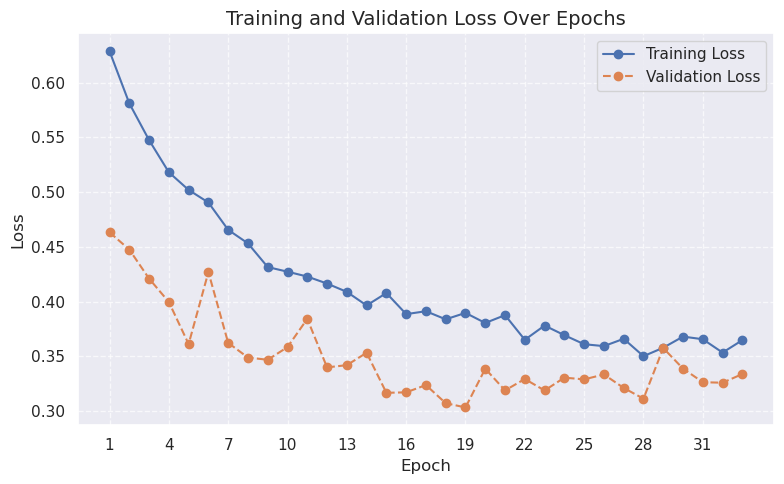

In [ ]:
from src.utils.plot import plot_training_loss

plot_training_loss(train_history["loss"], val_history["loss"])

In [ ]:
%aimport
from src.utils.train import evaluate_model

evaluate_model(
    model=model,
    test_loader=te_loader,
    device=device,
    checkpoint_path=SAVE_PATH,
    submission_path=SUBMISSION_ROOT / f"{SAVE_PATH.stem}.csv",
    use_gnn=True,
)

Modules to reload:


Modules to skip:

⚙️ Evaluating model. Loading model from: .checkpoints/lstm_gnn_generalizable_optimized.pt
   - Loading checkpoint from: .checkpoints/lstm_gnn_generalizable_optimized.pt
   - Detected full checkpoint dictionary.
   - Model state successfully loaded.
🧪 Performing inference on the test set...
   Generated 3614 predictions for 3614 IDs.
📄 Saved submission (3614 rows) → .submissions/lstm_gnn_generalizable_optimized.csv


,id,label
0,pqejgcvm_s001_t000_0,0
1,pqejgcvm_s001_t000_1,0
2,pqejgcvm_s001_t000_10,1
3,pqejgcvm_s001_t000_11,1
4,pqejgcvm_s001_t000_12,1
...,...,...
3609,pqejgvej_s001_t000_95,0
3610,pqejgvej_s001_t000_96,0
3611,pqejgvej_s001_t000_97,0
3612,pqejgvej_s001_t000_98,0
